In [5]:
import math
import random
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
import os

# ===============================
# Global Configuration
# ===============================
SEED = 11
SIM_DURATION_MS = 2_000_000  # total simulation time in milliseconds

def reset_seeds():
    """Reset RNGs for reproducibility between runs"""
    np.random.seed(SEED)
    random.seed(SEED)

# ===============================
# CTMC States
# ===============================
states = ["S1", "S12", "S2"]

# ===============================
# State → active machines
# ===============================
state_activity: Dict[str, List[str]] = {
    "S1":  ["M1"],
    "S12": ["M1", "M2"],
    "S2":  ["M2"],
}

# ===============================
# Base machine config
# ===============================
base_machines_config = [
    {"name": "M1", "slice": "URLLC", "dist": "normal",    "mean": 60,  "std": 5,  "ip": "10.0.0.1"},
    {"name": "M2", "slice": "eMBB",  "dist": "lognormal", "mean": 6.0, "std": 0.5,"ip": "10.0.0.2"},
]

# ===============================
# Per-slice interarrival
# ===============================
interarrival_cfg = {
    "URLLC": {"dist": "erlang", "k": 3, "mean_ms": 1.5},
    "eMBB":  {"dist": "lognormal", "mu": math.log(7.0), "sigma": 0.55},
}

uplink_ratio = {"URLLC": 0, "eMBB": 0}
SERVER_IP = "192.168.0.1"

# =======================================================
# Sampling helpers
# =======================================================
def sample_packet_size(m: Dict) -> float:
    if m["dist"] == "normal":
        return float(max(1.0, np.random.normal(m["mean"], m["std"])))
    elif m["dist"] == "lognormal":
        return float(np.random.lognormal(mean=m["mean"], sigma=m["std"]))
    else:
        raise ValueError(f"Unknown size dist: {m['dist']}")

def sample_interarrival_ms_for_slice(slice_type: str) -> float:
    cfg = interarrival_cfg[slice_type]
    if cfg["dist"] == "erlang":
        k = cfg["k"]
        scale = cfg["mean_ms"] / k
        return float(np.random.gamma(shape=k, scale=scale))
    elif cfg["dist"] == "lognormal":
        return float(np.random.lognormal(mean=cfg["mu"], sigma=cfg["sigma"]))
    else:
        raise ValueError(f"Unknown interarrival dist: {slice_type}")

def sample_direction(machine_ip: str, slice_type: str):
    if random.random() < uplink_ratio[slice_type]:
        return "UL", machine_ip, SERVER_IP
    else:
        return "DL", SERVER_IP, machine_ip

# =======================================================
# CTMC simulation
# =======================================================
def simulate_ctmc(Q: Dict[str, Dict[str, float]], start_state: str, t_end: float):
    timeline = []
    state = start_state
    t = 0.0
    while t < t_end:
        rates = Q.get(state, {})
        if not rates:
            timeline.append((state, t, t_end))
            break
        total = sum(rates.values())
        dwell = np.random.exponential(1.0 / total)
        seg_end = min(t + dwell, t_end)
        timeline.append((state, t, seg_end))
        t = seg_end
        if t >= t_end:
            break
        next_states = list(rates.keys())
        probs = np.array([rates[s] / total for s in next_states])
        state = np.random.choice(next_states, p=probs)
    return timeline

def extract_activity_intervals(timeline, state_activity):
    intervals = {}
    for st, t0, t1 in timeline:
        for ue in state_activity.get(st, []):
            intervals.setdefault(ue, []).append((t0, t1))
    return intervals

def generate_packets(intervals, machines_by_name):
    rows = []
    for ue, spans in intervals.items():
        m = machines_by_name[ue]
        slice_type = m["slice"]
        for (start_ms, end_ms) in spans:
            t = start_ms
            while True:
                t += sample_interarrival_ms_for_slice(slice_type)
                if t > end_ms:
                    break
                size = sample_packet_size(m)
                direction, src, dst = sample_direction(m["ip"], slice_type)
                rows.append({
                    "Time": round(t, 3),
                    "machine": ue,
                    "slice": slice_type,
                    "direction": direction,
                    "Source": src,
                    "Destination": dst,
                    "Length": round(size, 2),
                })
    return rows

# =======================================================
# Trace generation and alignment (with sec conversion)
# =======================================================
def run_trace(Q, machines_config, label):
    machines_by_name = {m["name"]: m for m in machines_config}

    # --- Simulate trace ---
    timeline = simulate_ctmc(Q, "S1", SIM_DURATION_MS)
    activity = extract_activity_intervals(timeline, state_activity)
    packet_rows = generate_packets(activity, machines_by_name)
    trace_df = pd.DataFrame(packet_rows).sort_values(["Time", "machine"]).reset_index(drop=True)

    print(f"   • {label}: {len(trace_df)} packets total "
          f"({(trace_df['machine'] == 'M1').sum()} M1, {(trace_df['machine'] == 'M2').sum()} M2)")

    # --- Convert to seconds ---
    timeline_df = pd.DataFrame(timeline, columns=["state", "start_ms", "end_ms"])
    intervals_df = pd.DataFrame(
        [{"machine": ue, "start_ms": a, "end_ms": b} for ue, spans in activity.items() for (a, b) in spans]
    )

    for df in [timeline_df, intervals_df, trace_df]:
        for col in df.columns:
            if col.endswith("_ms") or col == "Time":
                df[col] = df[col] / 1000.0

    # --- Save outputs ---
    os.makedirs("traces", exist_ok=True)
    base = f"traces/{label}"
    timeline_df.to_csv(f"{base}_timeline_sec.csv", index=False)
    intervals_df.to_csv(f"{base}_ue_activity_intervals_sec.csv", index=False)
    trace_df.to_csv(f"{base}_all_traces_sec.csv", index=False)
    print(f"✅ Saved traces for {label}")

# =======================================================
# Main variations
# =======================================================
def main():
    alphas = [0.25, 0.5, 1, 1.5, 2]
    betas  = [0.25, 0.5, 1, 1.5, 2]
    std1_vals = [1, 3, 5, 7, 9, 11, 13]
    std2_vals = [0.1, 0.3, 0.5, 0.9]

    # --- α variations (β fixed) ---
    for alpha in alphas:
        reset_seeds()
        Q = {
            "S1":  {"S12": alpha * 0.40, "S2": alpha * 0.35},
            "S12": {"S2": 0.20},
            "S2":  {"S1": 0.20},
        }
        run_trace(Q, base_machines_config, f"alpha_{alpha}")

    # --- β variations (α fixed) ---
    for beta in betas:
        reset_seeds()
        Q = {
            "S1":  {"S12": 0.40, "S2": 0.35},
            "S12": {"S2": 0.20},
            "S2":  {"S1": beta * 0.20},
        }
        run_trace(Q, base_machines_config, f"beta_{beta}")

    # --- std1 variations (std2 fixed at 0.5) ---
    for std1 in std1_vals:
        reset_seeds()
        machines_config = [
            {"name": "M1", "slice": "URLLC", "dist": "normal", "mean": 60, "std": std1, "ip": "10.0.0.1"},
            {"name": "M2", "slice": "eMBB",  "dist": "lognormal", "mean": 6.0, "std": 0.5, "ip": "10.0.0.2"},
        ]
        Q = {
            "S1":  {"S12": 0.40, "S2": 0.35},
            "S12": {"S2": 0.20},
            "S2":  {"S1": 0.20},
        }
        run_trace(Q, machines_config, f"std1_{std1}")

    # --- std2 variations (std1 fixed at 5) ---
    for std2 in std2_vals:
        reset_seeds()
        machines_config = [
            {"name": "M1", "slice": "URLLC", "dist": "normal", "mean": 60, "std": 5, "ip": "10.0.0.1"},
            {"name": "M2", "slice": "eMBB",  "dist": "lognormal", "mean": 6.0, "std": std2, "ip": "10.0.0.2"},
        ]
        Q = {
            "S1":  {"S12": 0.40, "S2": 0.35},
            "S12": {"S2": 0.20},
            "S2":  {"S1": 0.20},
        }
        run_trace(Q, machines_config, f"std2_{std2}")

if __name__ == "__main__":
    main()


   • alpha_0.25: 830097 packets total (744903 M1, 85194 M2)
✅ Saved traces for alpha_0.25
   • alpha_0.5: 705541 packets total (598440 M1, 107101 M2)
✅ Saved traces for alpha_0.5
   • alpha_1: 619559 packets total (496655 M1, 122904 M2)
✅ Saved traces for alpha_1
   • alpha_1.5: 588565 packets total (459019 M1, 129546 M2)
✅ Saved traces for alpha_1.5
   • alpha_2: 574557 packets total (441470 M1, 133087 M2)
✅ Saved traces for alpha_2
   • beta_0.25: 381617 packets total (186545 M1, 195072 M2)
✅ Saved traces for beta_0.25
   • beta_0.5: 481237 packets total (319247 M1, 161990 M2)
✅ Saved traces for beta_0.5
   • beta_1: 619559 packets total (496655 M1, 122904 M2)
✅ Saved traces for beta_1
   • beta_1.5: 713602 packets total (610046 M1, 103556 M2)
✅ Saved traces for beta_1.5
   • beta_2: 780546 packets total (687697 M1, 92849 M2)
✅ Saved traces for beta_2
   • std1_1: 619559 packets total (496655 M1, 122904 M2)
✅ Saved traces for std1_1
   • std1_3: 619559 packets total (496655 M1, 12290

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

def plot_activity(intervals_file, label):
    """Plot machine activity timeline for alpha/beta runs"""
    df = pd.read_csv(intervals_file)
    ZOOM_END = 0.1
    df = df[df["start_ms"] <= ZOOM_END]

    machine_colors = {"M1": "#1f77b4", "M2": "#ff7f0e"}

    plt.figure(figsize=(12, 3))
    for i, (machine, group) in enumerate(sorted(df.groupby("machine"))):
        for _, row in group.iterrows():
            plt.barh(
                y=i,
                width=row["end_ms"] - row["start_ms"],
                left=row["start_ms"],
                color=machine_colors.get(machine, "gray"),
                edgecolor="black",
                height=0.4,
            )

    plt.yticks(range(len(machine_colors)), machine_colors.keys())
    plt.xlabel("Time (sec)")
    plt.ylabel("Machine")
    plt.title(f"Machine Activity Timeline ({label}) – First {ZOOM_END}s")
    plt.grid(True, axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()

    handles = [mpatches.Patch(color=c, label=m) for m, c in machine_colors.items()]
    plt.legend(handles=handles, loc="upper right")

    os.makedirs("plots", exist_ok=True)
    fname = f"plots/activity_{label}.png"
    plt.savefig(fname, dpi=150)
    plt.close()
    print(f"   ↳ Saved activity plot: {fname}")


def plot_packet_distribution(trace_file, label):
    """Plot packet size histograms for std runs"""
    trace_df = pd.read_csv(trace_file)
    ZOOM_END = 10
    trace_zoom = trace_df[trace_df["Time"] <= ZOOM_END]

    os.makedirs("plots", exist_ok=True)

    # Combined plot
    plt.figure(figsize=(10, 4))
    sns.histplot(data=trace_zoom, x="Length", hue="slice", bins=80, kde=True, element="step")
    plt.title(f"Packet Size Distribution ({label}) – First {ZOOM_END}s")
    plt.xlabel("Packet Size (bytes)")
    plt.ylabel("Frequency")
    plt.xlim(0, trace_zoom["Length"].quantile(0.99))
    plt.tight_layout()
    plt.savefig(f"plots/packet_{label}.png", dpi=150)
    plt.close()

    # Per-slice plots
    for slice_type, group in trace_zoom.groupby("slice"):
        plt.figure(figsize=(8, 3))
        sns.histplot(group["Length"], bins=60, kde=True, color="C0")
        plt.title(f"{slice_type} – Packet Size Distribution ({label}) – First {ZOOM_END}s")
        plt.xlabel("Packet Size (bytes)")
        plt.ylabel("Frequency")
        plt.xlim(0, group["Length"].quantile(0.99))
        plt.tight_layout()
        plt.savefig(f"plots/packet_{slice_type}_{label}.png", dpi=150)
        plt.close()


In [7]:
# =======================================================
# After all runs: create summary plots
# =======================================================
import glob

print("\n=== Generating plots for all configurations ===")

# --- Activity plots for alpha/beta runs ---
for file in glob.glob("traces/*_ue_activity_intervals_sec.csv"):
    label = os.path.basename(file).replace("_ue_activity_intervals_sec.csv", "")
    if label.startswith(("alpha_", "beta_")):
        plot_activity(file, label)

# --- Packet size plots for std runs ---
for file in glob.glob("traces/*_all_traces_sec.csv"):
    label = os.path.basename(file).replace("_all_traces_sec.csv", "")
    if label.startswith(("std1_", "std2_")):
        plot_packet_distribution(file, label)

print("✅ All plots generated and saved in the 'plots/' folder.")



=== Generating plots for all configurations ===
   ↳ Saved activity plot: plots/activity_alpha_2.png
   ↳ Saved activity plot: plots/activity_alpha_0.5.png
   ↳ Saved activity plot: plots/activity_beta_1.5.png
   ↳ Saved activity plot: plots/activity_alpha_0.25.png
   ↳ Saved activity plot: plots/activity_alpha_1.5.png
   ↳ Saved activity plot: plots/activity_beta_0.5.png
   ↳ Saved activity plot: plots/activity_beta_2.png
   ↳ Saved activity plot: plots/activity_beta_1.png
   ↳ Saved activity plot: plots/activity_alpha_1.png
   ↳ Saved activity plot: plots/activity_beta_0.25.png
✅ All plots generated and saved in the 'plots/' folder.


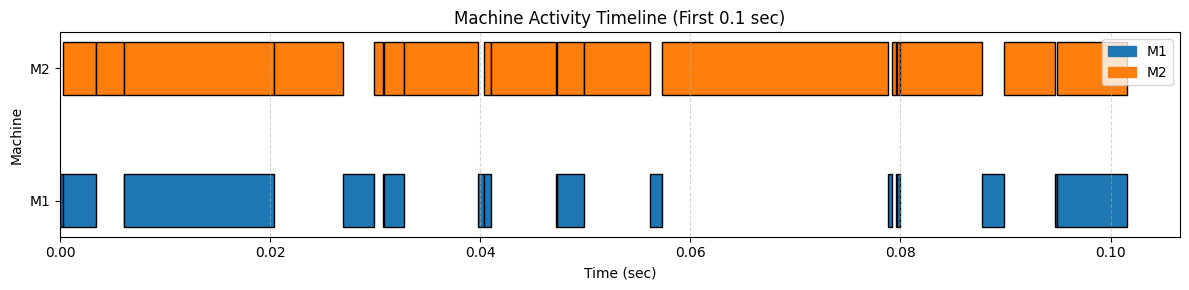

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load intervals (already in seconds)
activity_df = pd.read_csv("ue_activity_intervals_sec.csv")

# --- zoom window (set as you like) ---
ZOOM_END = 0.1     # seconds (for first 0.1 s)
activity_df = activity_df[activity_df["start_ms"] <= ZOOM_END]

# --- Assign colors per machine ---
machine_colors = {
    "M1": "#1f77b4",  # blue
    "M2": "#ff7f0e",  # orange
}

plt.figure(figsize=(12, 3))
for i, (machine, group) in enumerate(sorted(activity_df.groupby("machine"))):
    for _, row in group.iterrows():
        plt.barh(
            y=i,
            width=row["end_ms"] - row["start_ms"],
            left=row["start_ms"],
            color=machine_colors.get(machine, "gray"),
            edgecolor="black",
            height=0.4,
        )

# --- Formatting ---
plt.yticks(range(len(machine_colors)), machine_colors.keys())
plt.xlabel("Time (sec)")
plt.ylabel("Machine")
plt.title(f"Machine Activity Timeline (First {ZOOM_END} sec)")
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()

# Legend
handles = [mpatches.Patch(color=c, label=m) for m, c in machine_colors.items()]
plt.legend(handles=handles, loc="upper right")

plt.show()


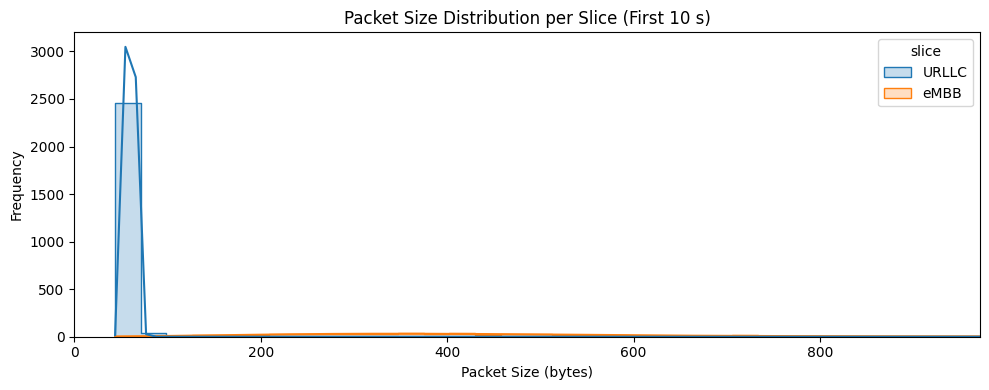

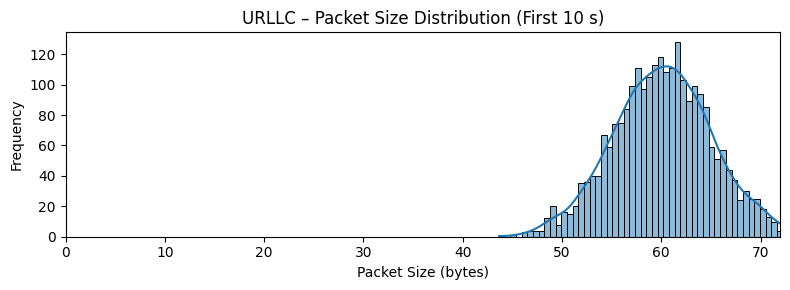

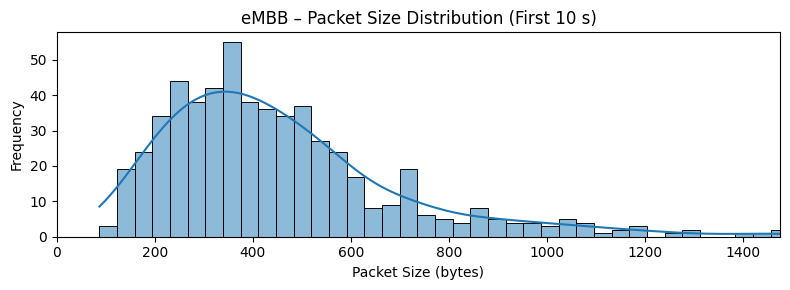

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

trace_df = pd.read_csv("all_traces_sec.csv")

# --- zoom window ---
ZOOM_END = 10  # seconds, same as activity plot
trace_zoom = trace_df[trace_df["Time"] <= ZOOM_END]

# --- combined distribution (all slices together) ---
plt.figure(figsize=(10, 4))
sns.histplot(data=trace_zoom, x="Length", hue="slice", bins=80, kde=True, element="step")
plt.title(f"Packet Size Distribution per Slice (First {ZOOM_END} s)")
plt.xlabel("Packet Size (bytes)")
plt.ylabel("Frequency")
plt.xlim(0, trace_zoom["Length"].quantile(0.99))  # cut off extreme tail
plt.tight_layout()
plt.show()

# --- per-slice distributions separately ---
for slice_type, group in trace_zoom.groupby("slice"):
    plt.figure(figsize=(8, 3))
    sns.histplot(group["Length"], bins=60, kde=True, color="C0")
    plt.title(f"{slice_type} – Packet Size Distribution (First {ZOOM_END} s)")
    plt.xlabel("Packet Size (bytes)")
    plt.ylabel("Frequency")
    plt.xlim(0, group["Length"].quantile(0.99))
    plt.tight_layout()
    plt.show()


In [ ]:
### Inter arrival times per slice analysis

### The effect of alpha and beta (dwell time)

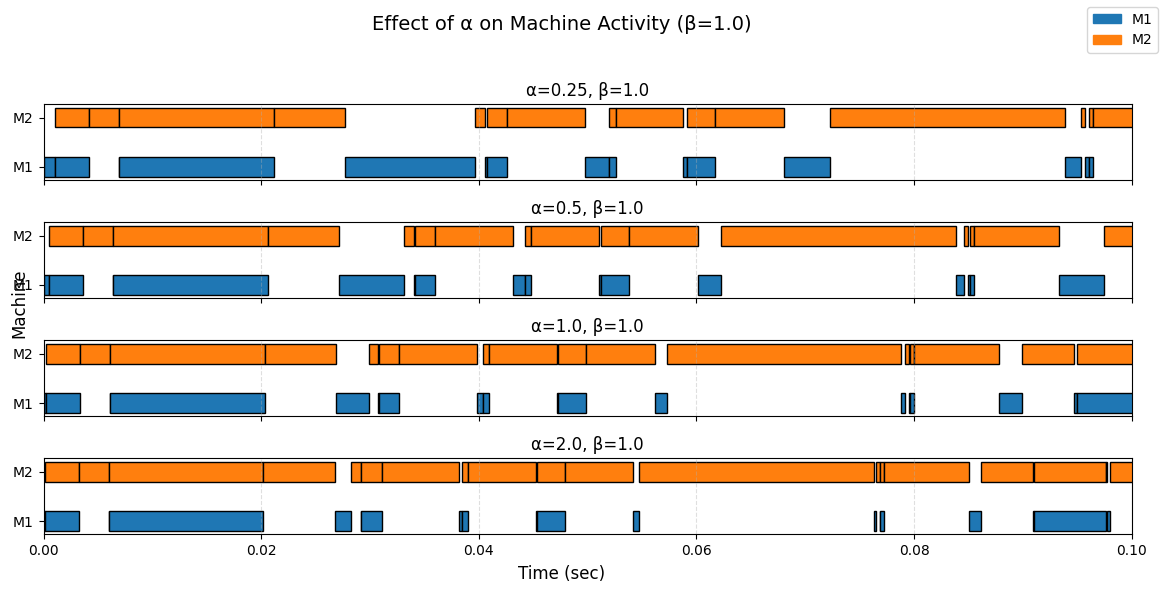

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np

# reuse your simulate_ctmc, extract_activity_intervals, state_activity definitions

alphas = [0.25, 0.5, 1.0, 2.0]
beta_fixed = 1.0
ZOOM_END = 0.1
machine_colors = {"M1": "#1f77b4", "M2": "#ff7f0e"}

fig, axes = plt.subplots(len(alphas), 1, figsize=(12, 6), sharex=True, sharey=True)

for i, alpha in enumerate(alphas):
    # --- redefine Q for this alpha ---
    Q = {
        "S1":  {"S12": alpha * 0.40, "S2": alpha * 0.35},
        "S12": {"S2": 0.20},
        "S2":  {"S1": beta_fixed * 0.20},
    }

    np.random.seed(11)
    timeline = simulate_ctmc(Q, start_state="S1", t_end=2_000_000)
    activity = extract_activity_intervals(timeline, state_activity)
    act_df = pd.DataFrame(
        [{"machine": ue, "start_ms": a/1000, "end_ms": b/1000}
         for ue, spans in activity.items() for (a, b) in spans]
    )

    # zoom to first 0.1 s
    act_df = act_df[act_df["start_ms"] <= ZOOM_END]

    # plot
    ax = axes[i]
    for k, (machine, group) in enumerate(sorted(act_df.groupby("machine"))):
        for _, row in group.iterrows():
            ax.barh(
                y=k,
                width=row["end_ms"] - row["start_ms"],
                left=row["start_ms"],
                color=machine_colors[machine],
                edgecolor="black",
                height=0.4,
            )
    ax.set_xlim(0, ZOOM_END)
    ax.set_title(f"α={alpha}, β={beta_fixed}")
    ax.set_yticks(range(len(machine_colors)))
    ax.set_yticklabels(machine_colors.keys())
    ax.grid(True, axis="x", linestyle="--", alpha=0.4)

fig.text(0.5, 0.04, "Time (sec)", ha="center", fontsize=12)
fig.text(0.04, 0.5, "Machine", va="center", rotation="vertical", fontsize=12)
fig.suptitle(f"Effect of α on Machine Activity (β={beta_fixed})", fontsize=14)
fig.tight_layout(rect=[0.03, 0.05, 1, 0.95])
handles = [mpatches.Patch(color=c, label=m) for m, c in machine_colors.items()]
fig.legend(handles=handles, loc="upper right")
plt.show()


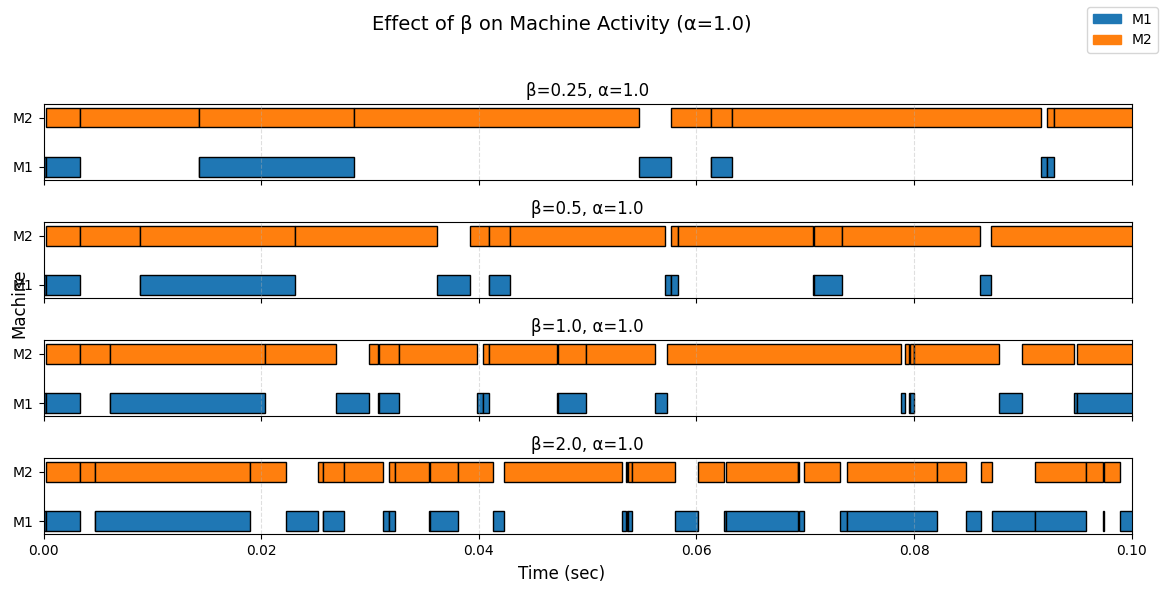

In [8]:
betas = [0.25, 0.5, 1.0, 2.0]
alpha_fixed = 1.0
ZOOM_END = 0.1
machine_colors = {"M1": "#1f77b4", "M2": "#ff7f0e"}

fig, axes = plt.subplots(len(betas), 1, figsize=(12, 6), sharex=True, sharey=True)

for i, beta in enumerate(betas):
    Q = {
        "S1":  {"S12": alpha_fixed * 0.40, "S2": alpha_fixed * 0.35},
        "S12": {"S2": 0.20},
        "S2":  {"S1": beta * 0.20},
    }

    np.random.seed(11)
    timeline = simulate_ctmc(Q, start_state="S1", t_end=2_000_000)
    activity = extract_activity_intervals(timeline, state_activity)
    act_df = pd.DataFrame(
        [{"machine": ue, "start_ms": a/1000, "end_ms": b/1000}
         for ue, spans in activity.items() for (a, b) in spans]
    )

    act_df = act_df[act_df["start_ms"] <= ZOOM_END]

    ax = axes[i]
    for k, (machine, group) in enumerate(sorted(act_df.groupby("machine"))):
        for _, row in group.iterrows():
            ax.barh(
                y=k,
                width=row["end_ms"] - row["start_ms"],
                left=row["start_ms"],
                color=machine_colors[machine],
                edgecolor="black",
                height=0.4,
            )
    ax.set_xlim(0, ZOOM_END)
    ax.set_title(f"β={beta}, α={alpha_fixed}")
    ax.set_yticks(range(len(machine_colors)))
    ax.set_yticklabels(machine_colors.keys())
    ax.grid(True, axis="x", linestyle="--", alpha=0.4)

fig.text(0.5, 0.04, "Time (sec)", ha="center", fontsize=12)
fig.text(0.04, 0.5, "Machine", va="center", rotation="vertical", fontsize=12)
fig.suptitle(f"Effect of β on Machine Activity (α={alpha_fixed})", fontsize=14)
fig.tight_layout(rect=[0.03, 0.05, 1, 0.95])
handles = [mpatches.Patch(color=c, label=m) for m, c in machine_colors.items()]
fig.legend(handles=handles, loc="upper right")
plt.show()


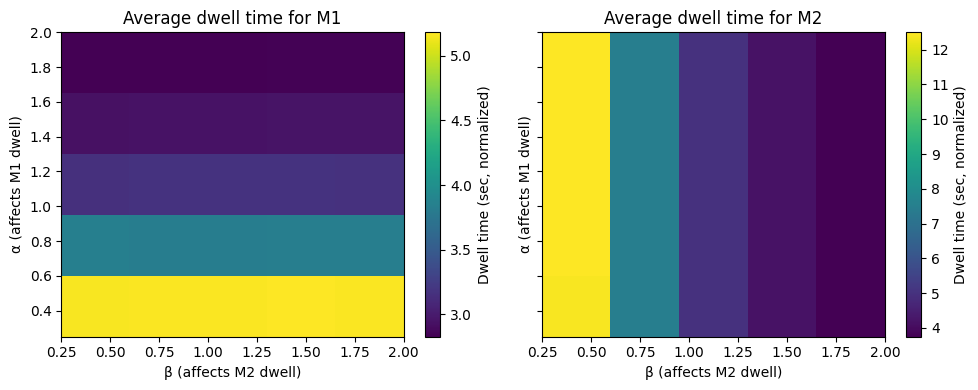

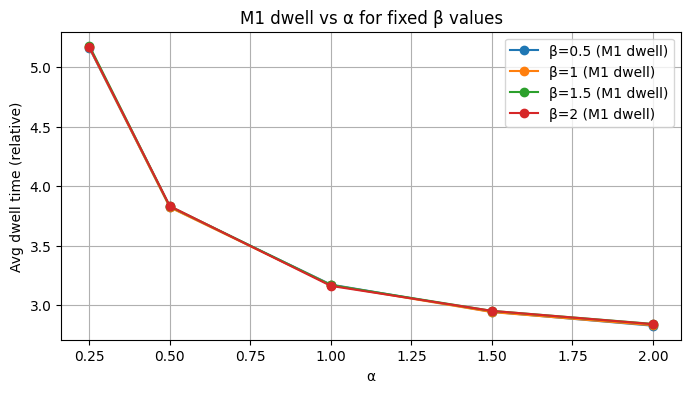

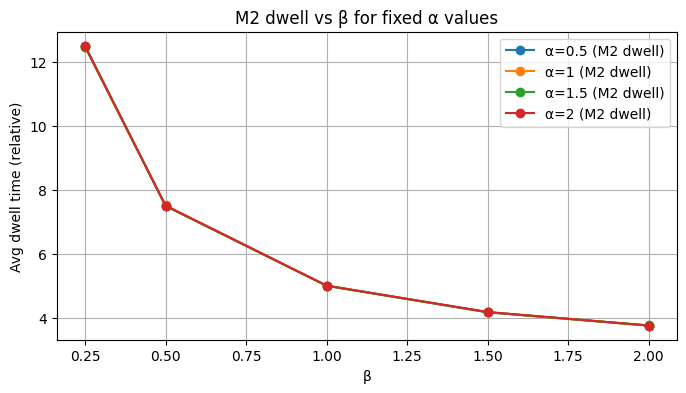

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(11)

SIM_DURATION_MS = 2_000_000
alphas = [0.25, 0.5, 1, 1.5, 2]
betas  = [0.25, 0.5, 1, 1.5, 2]
state_activity = {"S1": ["M1"], "S12": ["M1", "M2"], "S2": ["M2"]}

def simulate_ctmc(Q, start_state="S1", t_end=SIM_DURATION_MS):
    timeline = []
    state = start_state
    t = 0.0
    while t < t_end:
        rates = Q.get(state, {})
        total = sum(rates.values())
        dwell = np.random.exponential(1.0 / total)
        end_t = min(t + dwell, t_end)
        timeline.append((state, dwell))
        t = end_t
        if t >= t_end:
            break
        next_states = list(rates.keys())
        probs = np.array([rates[s] / total for s in next_states])
        state = np.random.choice(next_states, p=probs)
    return pd.DataFrame(timeline, columns=["state", "dwell"])

def avg_dwell_for_machines(df):
    dwell = {"M1": 0, "M2": 0}
    total = df.groupby("state")["dwell"].mean().to_dict()
    dwell["M1"] = np.mean([total.get("S1",0), total.get("S12",0)])
    dwell["M2"] = np.mean([total.get("S2",0), total.get("S12",0)])
    return dwell

results = []

for a in alphas:
    for b in betas:
        Q = {
            "S1":  {"S12": a * 0.40, "S2": a * 0.35},
            "S12": {"S2": 0.20},
            "S2":  {"S1": b * 0.20},
        }
        timeline = simulate_ctmc(Q)
        dwell = avg_dwell_for_machines(timeline)
        results.append({"alpha": a, "beta": b, **dwell})

res_df = pd.DataFrame(results)

# --- Plot dwell times vs alpha and beta ---
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
for m, ax in zip(["M1", "M2"], axes):
    pivot = res_df.pivot(index="alpha", columns="beta", values=m)
    im = ax.imshow(pivot, origin="lower", aspect="auto", cmap="viridis",
                   extent=[min(betas), max(betas), min(alphas), max(alphas)])
    ax.set_xlabel("β (affects M2 dwell)")
    ax.set_ylabel("α (affects M1 dwell)")
    ax.set_title(f"Average dwell time for {m}")
    fig.colorbar(im, ax=ax, label="Dwell time (sec, normalized)")
plt.tight_layout()
plt.show()

# --- 1D line plots for clearer view ---
plt.figure(figsize=(8,4))
for b in [0.5, 1, 1.5, 2]:
    subset = res_df[res_df["beta"]==b]
    plt.plot(subset["alpha"], subset["M1"], marker="o", label=f"β={b} (M1 dwell)")
plt.title("M1 dwell vs α for fixed β values")
plt.xlabel("α")
plt.ylabel("Avg dwell time (relative)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
for a in [0.5, 1, 1.5, 2]:
    subset = res_df[res_df["alpha"]==a]
    plt.plot(subset["beta"], subset["M2"], marker="o", label=f"α={a} (M2 dwell)")
plt.title("M2 dwell vs β for fixed α values")
plt.xlabel("β")
plt.ylabel("Avg dwell time (relative)")
plt.legend()
plt.grid(True)
plt.show()
